# Classification of Harmful InsectsUsing Convolutional NeuralNetworks (CNN)

# Introduction
<a id="Introduction"></a>
In agriculture, identifying harmful insects is crucial for effective pest management and crop protection. This notebook aims to develop a deep learning model to automatically classify harmful insects based on images, providing a sort of reliable and efficient solution for pest identification.

# Table of Contents

1. [Introduction](#Introduction)  
2. [Objectives](#Objectives)  
3. [Problematic](#Problematic)  
4. [Use Cases](#Use-Cases)  
5. [Dataset Overview](#Dataset-Overview)  
6. [Implementation](#Implementation)  
   6.1. [Importing Libraries](#Importing-Libraries)  
   6.2. [Fetching Image Counts](#Fetching-Image-Counts)  
   6.3. [Loading Images into Arrays](#Loading-Images-into-Arrays)  
   6.4. [Dataset Exploration](#Dataset-Exploration)  
   6.5. [Data Preprocessing](#Data-Preprocessing)  
   6.6. [Data Augmentation](#Data-Augmentation)  
   6.7. [Model Creation](#Model-Creation)  
   6.8. [Model Compilation](#Model-Compilation)  
   6.9. [Model Training](#Model-Training)  
   6.10. [Model Evaluation](#Model-Evaluation)  
   6.11. [Image Classification Function](#Image-Classification-Function)  
   6.12. [Saving the Model](#Saving-the-Model)   
7. [Conclusion](#Conclusion)  
 

# Objectives
<a id="Objectives"></a>

- Build a convolutional neural network (CNN) model to classify harmful insects into 15 distinct categories.
- Preprocess and augment the dataset to improve model generalization.
- Evaluate the model’s performance using accuracy, precision, recall, and F1-score.
- Create a user-friendly function to classify new images using the trained model.

# Problematic
<a id="Problematic"></a>

- Class imbalance in the dataset, with some insect classes having fewer images than others.
- Variability in image quality, lighting, and background.
- Overfitting due to the limited size of the dataset.



# Use Cases
<a id="Use-Cases"></a>

- **Farmers:** Quickly identify harmful insects in their fields and take appropriate action.  
- **Agricultural Advisors:** Provide accurate pest identification and management recommendations.  
- **Researchers:** Study the distribution and impact of harmful insects in different regions.

# Dataset Overview
<a id="Dataset-Overview"></a>

The dataset consists of 2790 images divided into 15 classes of harmful insects. Downloaded from Kaggle dataset called “ Dangerous Farm Insects Dataset ”  https://www.kaggle.com/datasets/tarundalal/dangerous-insects-dataset

also from another Kaggle dataset called “ Agricultural Pests Image Dataset ” to hellp augment the dataset manually and avoid overfiting https://www.kaggle.com/datasets/vencerlanz09/agricultural-pests-image-dataset

Each class represents a specific type of insect and The images are organized into subfolders with each subfolder corresponding to a class.

# Implementation
<a id="Implementation"></a>

## 6.1. Importing Libraries
<a id="Importing-Libraries"></a>
The necessary libraries for data processing, visualization, and deep learning are imported. 

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## 6.2. Fetching Image Counts
<a id="Fetching-Image-Counts"></a>
The script counts the number of images in each class folder to understand the dataset distribution.

In [84]:
base_dir = 'C:/Users/ETS MESSAHEL/Downloads/farm_insects/'
count = 0 
dirs = os.listdir('C:/Users/ETS MESSAHEL/Downloads/farm_insects/')

for dir in dirs:
    files = list(os.listdir('C:/Users/ETS MESSAHEL/Downloads/farm_insects/'+dir))
    print( dir +' Folder has '+ str(len(files)) + ' Images')
    count = count + len(files)
print( 'Images Folder has '+ str(count) + ' Images')

Africanized Honey Bees (Killer Bees) Folder has 185 Images
Aphids Folder has 186 Images
Armyworms Folder has 186 Images
Brown Marmorated Stink Bugs Folder has 185 Images
Cabbage Loopers Folder has 186 Images
Citrus Canker Folder has 186 Images
Colorado Potato Beetles Folder has 186 Images
Corn Borers Folder has 186 Images
Corn Earworms Folder has 184 Images
Fruit Flies Folder has 187 Images
Grasshopper Folder has 189 Images
Spider Mites Folder has 188 Images
Thrips Folder has 186 Images
Tomato Hornworms Folder has 183 Images
Western Corn Rootworms Folder has 187 Images
Images Folder has 2790 Images


In [127]:
img_size = 180
batch = 32

## 6.3. Loading Images into Arrays
<a id="Loading-Images-into-Arrays"></a>
The images are loaded into arrays and split into training and validation datasets using TensorFlow’s `image_dataset_from_directory` function. The dataset is resized to a uniform size (180x180) and split into 80% training and 20% validation sets.

In [86]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2, 
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=123, 
    validation_split=0.2,
    subset='validation',
    batch_size=batch,
    image_size=(img_size, img_size)
)

Found 2790 files belonging to 15 classes.
Using 2232 files for training.
Found 2790 files belonging to 15 classes.
Using 558 files for validation.


In [87]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [88]:
insect_names = train_ds.class_names
insect_names

['Africanized Honey Bees (Killer Bees)',
 'Aphids',
 'Armyworms',
 'Brown Marmorated Stink Bugs',
 'Cabbage Loopers',
 'Citrus Canker',
 'Colorado Potato Beetles',
 'Corn Borers',
 'Corn Earworms',
 'Fruit Flies',
 'Grasshopper',
 'Spider Mites',
 'Thrips',
 'Tomato Hornworms',
 'Western Corn Rootworms']

## 6.4. Dataset Exploration

<a id="Dataset-Exploration"></a>
The class names are extracted from the dataset, and a bar plot is created to visualize the distribution of images across classes

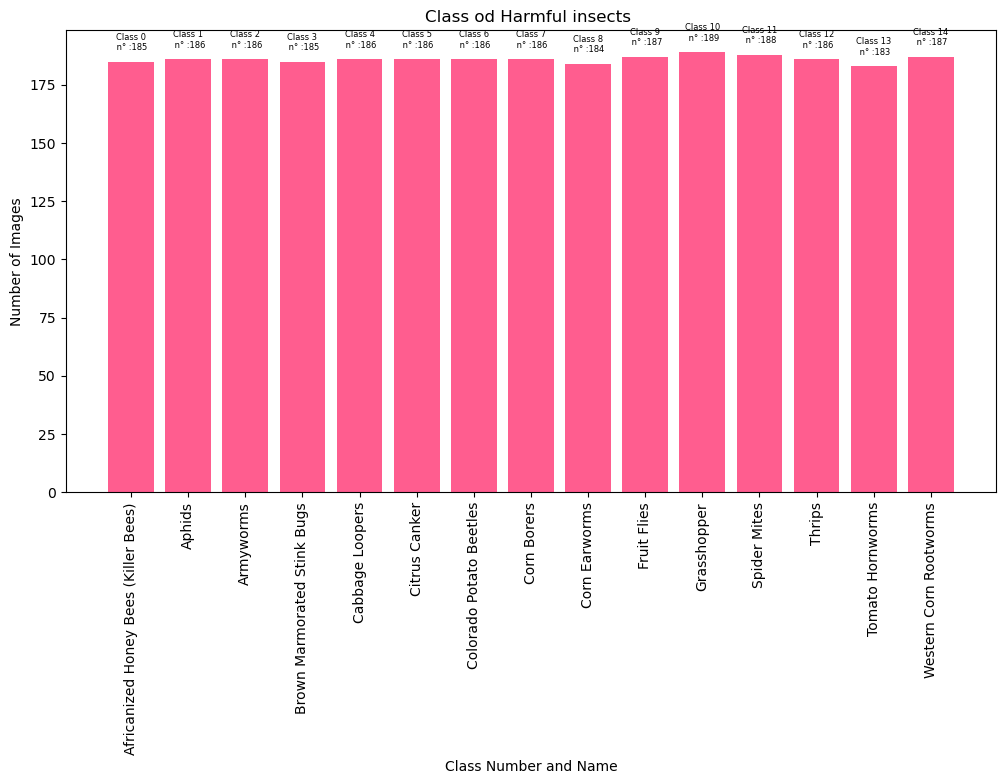

In [89]:
class_counts = {class_name: len(os.listdir(os.path.join(base_dir, class_name))) for class_name in insect_names}
class_number_to_name = {i: name for i, name in enumerate(insect_names)}
plt.figure(figsize=(12, 6))
plt.bar(range(len(class_counts)), class_counts.values(), tick_label=list(class_number_to_name.values()), color='#FF5D8F')
plt.title('Class od Harmful insects ')
plt.xlabel('Class Number and Name')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)

for i, (class_name, count) in enumerate(class_counts.items()):
    plt.text(i, count + 5, f'Class {i}\n n° :{count}', ha='center', rotation=0, fontsize=6)

plt.show()

<_TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


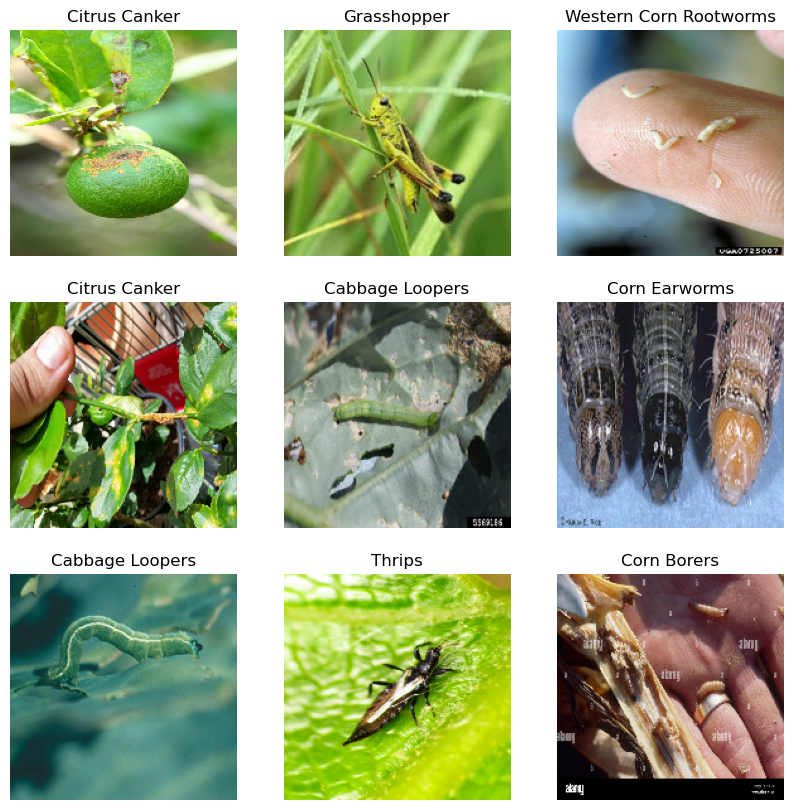

In [97]:
i = 0
plt.figure(figsize=(10,10))
print(train_ds.take(1))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(insect_names[labels[i]])
        plt.axis('off')

## 6.5. Data Preprocessing
<a id="Data-Preprocessing"></a>
The dataset is optimized using TensorFlow’s `AUTOTUNE` feature, which dynamically adjusts resource allocation for data loading. The training dataset is shuffled and cached to improve training efficiency, while the validation dataset is cached for faster evaluation.

In [128]:
AUTOTUNE = tf.data.AUTOTUNE
AUTOTUNE

-1

In [99]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [100]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

## 6.6. Data Augmentation
<a id="Data-Augmentation"></a>
A data augmentation pipeline is created to apply random transformations (e.g., flipping, rotation, zooming) to the training images. This helps the model generalize better and reduces overfitting by exposing it to varied versions of the same image.

In [101]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
    
])

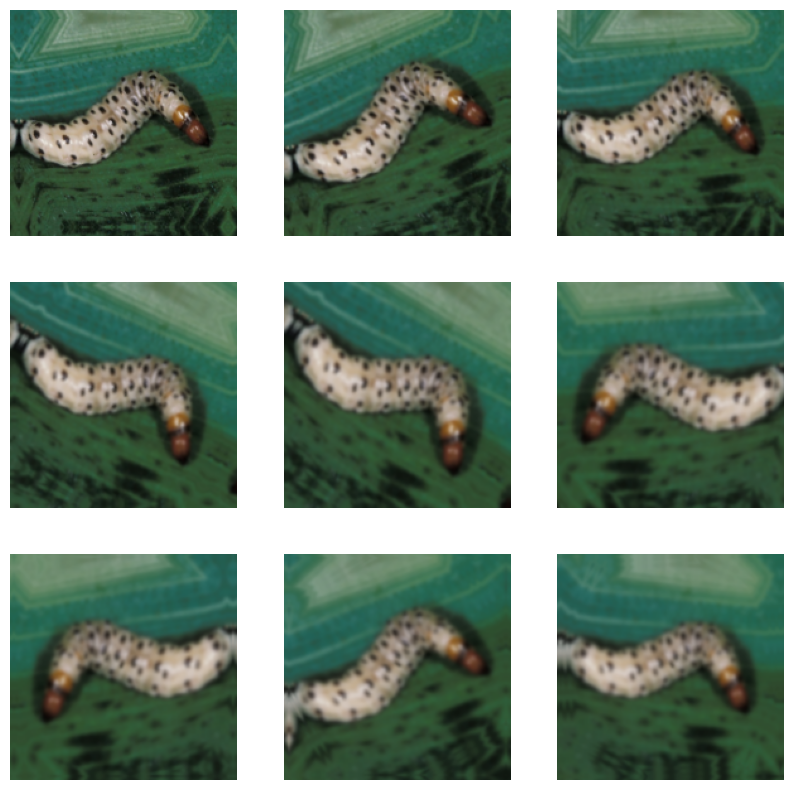

In [102]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

## 6.7. Model Creation
<a id="Model-Creation"></a>
A convolutional neural network (CNN) model is built using 'Sequential'  :
- Data augmentation and image normalization layers.
- Convolutional layers for feature extraction.
- Max-pooling layers for dimensionality reduction.
- Dropout layers to prevent overfitting.
- Fully connected layers for classification.

In [103]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2), 
    Flatten(),
    Dense(128, activation='relu'),
    Dense(15 , activation='softmax')
])

## 6.8. Model Compilation

<a id="Model-Compilation"></a>
The model is compiled using the Adam optimizer and SparseCategoricalCrossentropy loss function andAccuracy is used as the evaluation metric to monitor model performance during training.

In [104]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [105]:
model.summary() 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,990,575 (15.22 MB)

 Trainable params: 3,990,575 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

## 6.9. Model Training
<a id="Model-Training"></a>
The model is trained for 30 epochs on the training dataset, with validation performed on the validation dataset.
Training and validation metrics  are logged

In [48]:
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds) 

Epoch 1/30


C:\Users\ETS MESSAHEL\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


70/70 ━━━━━━━━━━━━━━━━━━━━ 35s 464ms/step - accuracy: 0.0983 - loss: 2.7302 - val_accuracy: 0.1559 - val_loss: 2.5376
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 302ms/step - accuracy: 0.1715 - loss: 2.4738 - val_accuracy: 0.2401 - val_loss: 2.3606
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 309ms/step - accuracy: 0.2557 - loss: 2.2417 - val_accuracy: 0.2921 - val_loss: 2.2924
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 24s 347ms/step - accuracy: 0.3275 - loss: 2.0260 - val_accuracy: 0.3118 - val_loss: 2.2321
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 371ms/step - accuracy: 0.3589 - loss: 1.9590 - val_accuracy: 0.3781 - val_loss: 2.0383
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 369ms/step - accuracy: 0.4298 - loss: 1.7731 - val_accuracy: 0.3871 - val_loss: 2.0026
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 366ms/step - accuracy: 0.4713 - loss: 1.6722 - val_accuracy: 0.4409 - val_loss: 1.8164
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 27s 379ms/step - accuracy: 0.5450 - loss: 1.4953 - val_accuracy: 0.422

this code to test our model on new unseen images.

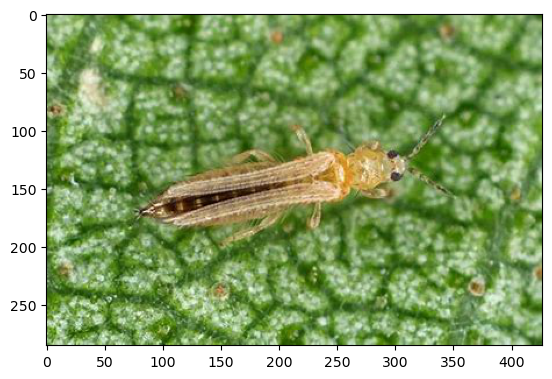

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
**************************************
tf.Tensor(
[ 5.987265   5.9873247  6.0000973  5.987703   5.987265   5.987282
  5.9999204  5.987864   5.987265   5.987265   5.987513   6.0053964
 16.121443   5.987265   5.9991355], shape=(15,), dtype=float32)


'The Image belongs to Thrips with a score of 16.12 %'

In [72]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180)) 
    input_image_array = tf.keras.utils.img_to_array(input_image)
#     print('input image array', input_image_array)

    input_image_exp_dim = tf.expand_dims(input_image_array,0)
#     print('input image expanded deminsion', input_image_exp_dim)

    predictions = model.predict(input_image_exp_dim)
#     print('predictions', predictions.shape)
    result = tf.nn.softmax(predictions[0])

    print('**************************************')
    outcome = 'The Image belongs to ' + flower_names[np.argmax(result)] + ' with a score of {:.2f}'.format(np.max(result) * 100) +' %'
    
    result = result *100
    print(result)
    return outcome

testt = 'C:/Users/ETS MESSAHEL/Downloads/tests/3.jpg'

image = mpimg.imread(testt)
plt.imshow(image)
plt.show()
classify_images(testt)

## 6.10. Model Evaluation
<a id="Model-Evaluation"></a>
The model’s performance is evaluated using:
- **Training and Validation Curves:** Plots of accuracy and loss over epochs to visualize learning progress.
- **Confusion Matrix:** A heatmap showing the model’s predictions versus true labels, highlighting areas of confusion between classes.
- **Classification Report:** Precision, recall, F1-score, and support for each class, providing a detailed breakdown of model performance.

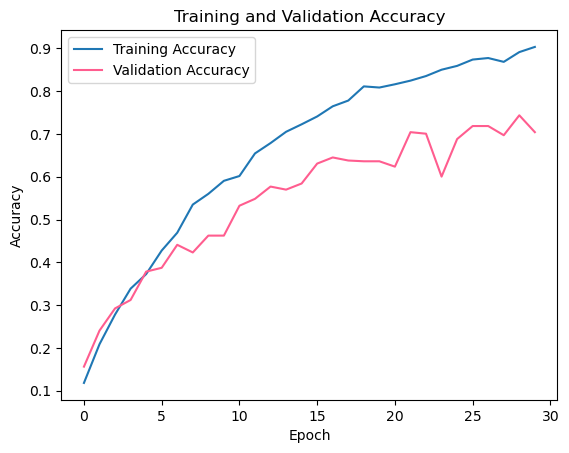

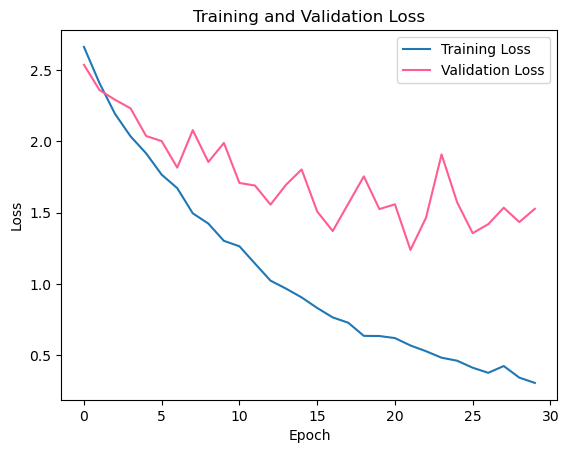

In [50]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy' , color="#FF5D8F")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss' , color="#FF5D8F")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


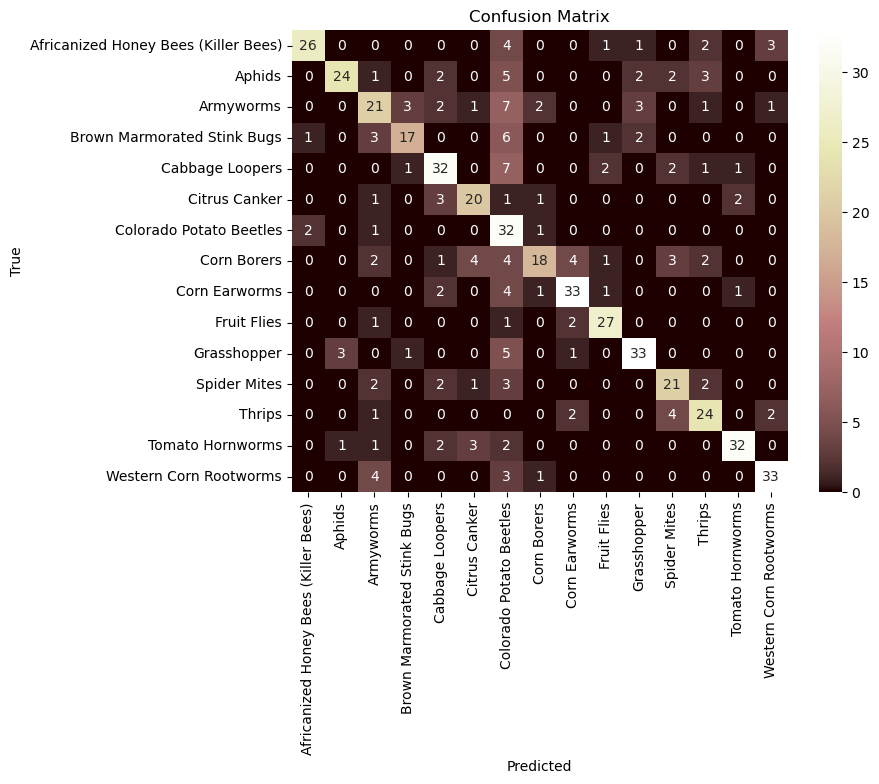

In [51]:
# Get predictions
y_pred = model.predict(val_ds) 
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='pink', xticklabels=insect_names, yticklabels=flower_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

High values on the diagonal indicate good performance.
Low values indicate that the model struggles to correctly classify that class

High off-diagonal values indicate confusion between classes.

## 6.11. Image Classification Function
<a id="Image-Classification-Function"></a>
A function is created to classify new images using the trained model. The function preprocesses the input image, generates predictions, and outputs the predicted class along with the confidence score.

In [52]:
print(classification_report(y_true, y_pred, target_names=insect_names))

                                      precision    recall  f1-score   support

Africanized Honey Bees (Killer Bees)       0.90      0.70      0.79        37
                              Aphids       0.86      0.62      0.72        39
                           Armyworms       0.55      0.51      0.53        41
         Brown Marmorated Stink Bugs       0.77      0.57      0.65        30
                     Cabbage Loopers       0.70      0.70      0.70        46
                       Citrus Canker       0.69      0.71      0.70        28
             Colorado Potato Beetles       0.38      0.89      0.53        36
                         Corn Borers       0.75      0.46      0.57        39
                       Corn Earworms       0.79      0.79      0.79        42
                         Fruit Flies       0.82      0.87      0.84        31
                         Grasshopper       0.80      0.77      0.79        43
                        Spider Mites       0.66      0.68      

## 6.12. Saving the Model
<a id="Saving-the-Model"></a>
The trained model is saved in the `.keras` format for future use, ensuring that it can be reloaded without retraining.

In [129]:
model.save('Recog_Model.keras')

# Conclusion
<a id="Conclusion"></a>
The project successfully builds and trains a CNN model for classifying harmful insects. 
While the model’s performance is promising, further improvements can be made by addressing class imbalance, experimenting with different architectures, and using transfer learning.